#DEPRESSION DETECTION THROUGH TEXT

##Importing Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download("omw-1.4")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences
import tensorflow as tf
import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Activation, Bidirectional, LSTM, Dropout, Embedding
from keras.losses import sparse_categorical_crossentropy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

##Dataset

In [ ]:
df=pd.read_excel("/content/drive/MyDrive/TweetsDataset/proj-tweetsDataset.xlsx")
dforig=df.copy()
df.head()

,Username,Date Created,Tweets,Label
0,TheReal_Kiara__,2023-02-28 16:11:18+00:00,Been silently going through depression and I a...,1.0
1,SeanJoh10108875,2023-02-28 16:06:01+00:00,Please i am going through a lot in my life rn...,1.0
2,FundilyMundelly,2023-02-28 14:16:26+00:00,@mrjamesob @MICKLE_M Maybe he can now give a t...,1.0
3,heart0fwar,2023-02-28 10:54:37+00:00,@Theholisticpsyc what timing. I am going throu...,1.0
4,JordanMezen,2023-02-27 22:46:29+00:00,I am going through a period of depression beca...,1.0


## EDA

###Basic

In [ ]:
df.shape

(13316, 4)

In [ ]:
df.isna().sum()

Username        0
Date Created    2
Tweets          3
Label           4
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.Label.value_counts()

1.0    7001
0.0    6310
Name: Label, dtype: int64

Text(0.5, 1.0, 'Distribution of Target')

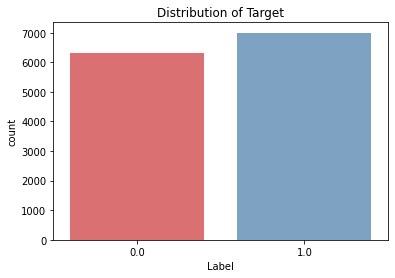

In [ ]:
sns.countplot(x = df['Label'], palette = 'Set1', alpha = 0.7)
plt.title('Distribution of Target')

In [ ]:
# Datetime object
df['Date Created']=df['Date Created'].apply(pd.to_datetime)
df["month"]=df['Date Created'].dt.month
df["year"]=df['Date Created'].dt.year

In [ ]:
# Filter Dataframe
neutral=df[df['Label']==0]
depressed=df[df['Label']==1]

In [ ]:
# Frequency of posts per year
tweetspy=df[['year','Tweets']].groupby('year').agg('count')
tweetspy

,Tweets
year,
2020,2698
2021,2945
2022,4801
2023,2867


###Text Normalization

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
sw=stopwords.words('english')
sw.extend(['going','im','one','u','dont'])
sw.remove('not')
lemma=WordNetLemmatizer()

In [ ]:
def preprocess(df):
  df["Tweets"] = df["Tweets"].str.lower()
  df["Tweets"] = df["Tweets"].str.replace('http[^\s]+','')
  df["Tweets"] = df["Tweets"].str.replace("\d","")
  df["Tweets"] = df["Tweets"].str.replace("-"," ")
  df["Tweets"] = df["Tweets"].str.replace("&amp","&")
  df['Tweets'] = df['Tweets'].str.replace("™","")
  df["Tweets"] = df["Tweets"].str.replace("[ðÿž]"," ")
  df["Tweets"] = df["Tweets"].str.replace("â€","'")  
  df["Tweets"] = df["Tweets"].str.replace("rt @[\w]+"," ")
  df["Tweets"] = df["Tweets"].str.replace('@[\w]+',' ')  
  #df['Tweets']=df['Tweets'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8') 
  df["Tweets"] = df["Tweets"].str.replace("[^\w\s]"," ")
  df["Tweets"] = df["Tweets"].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
  df["Tweets"] = df["Tweets"].apply(lambda x: " ".join(lemma.lemmatize(x) for x in x.split()))


In [ ]:
preprocess(df)

<ipython-input-9-edc6a6e2d52a>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df["Tweets"] = df["Tweets"].str.replace('http[^\s]+','')
<ipython-input-9-edc6a6e2d52a>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df["Tweets"] = df["Tweets"].str.replace("\d","")
<ipython-input-9-edc6a6e2d52a>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df["Tweets"] = df["Tweets"].str.replace("[ðÿž]"," ")
<ipython-input-9-edc6a6e2d52a>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df["Tweets"] = df["Tweets"].str.replace("rt @[\w]+"," ")
<ipython-input-9-edc6a6e2d52a>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df["Tweets"] = df["Tweets"].str.replace('@[\w]+',' ')
<ipython-input-9-edc6a6e2d52a>:13: FutureWarning: The default value of regex w

In [ ]:
sw

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
df['original_tweets']=dforig.Tweets
df[['original_tweets','Tweets']].head()

,original_tweets,Tweets
0,Been silently going through depression and I a...,silently depression happy feeling better today
1,Please i am going through a lot in my life rn...,please lot life rn suffering depression think ...
2,@mrjamesob @MICKLE_M Maybe he can now give a t...,maybe give thought thousand owner smes probabl...
3,@Theholisticpsyc what timing. I am going throu...,timing recently opted take week break social m...
4,I am going through a period of depression beca...,period depression family understands even girl...


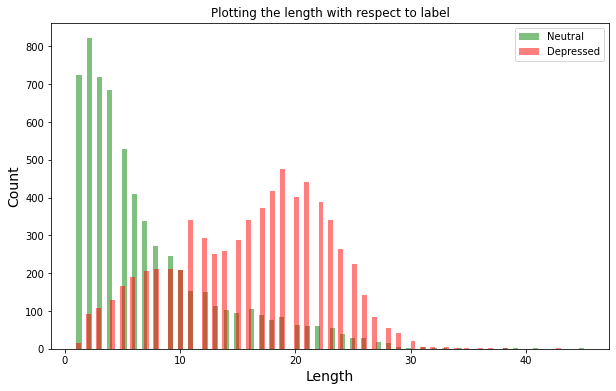

In [ ]:
# Length of Text
df["frequency"] = df["Tweets"].apply(lambda x: len(str(x).split(" "))) 
plt.figure(figsize=(10,6))
plt.hist(df[df.Label==0]['frequency'], bins=100, alpha=0.5,color = 'g', label="Neutral")
plt.hist(df[df.Label==1]['frequency'], bins=100, alpha=0.5,color = 'r', label="Depressed")
plt.xlabel("Length", size=14)
plt.ylabel("Count", size=14)
plt.title("Plotting the length with respect to label")
plt.legend(loc='upper right')

###WordCloud

Text(0.5, 1.0, 'Overall Tweets')

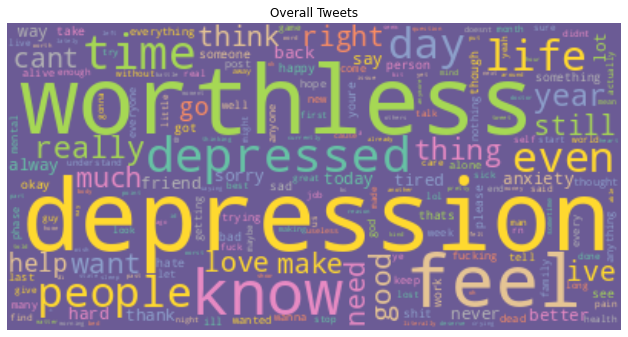

In [ ]:
text = " ".join(i for i in df.Tweets)
wordcloud = WordCloud(background_color="#6B5B95",colormap="Set2",collocations=False).generate(text)
plt.figure(figsize=[11,11])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Overall Tweets")

Text(0.5, 1.0, 'The Tweets About Depression')

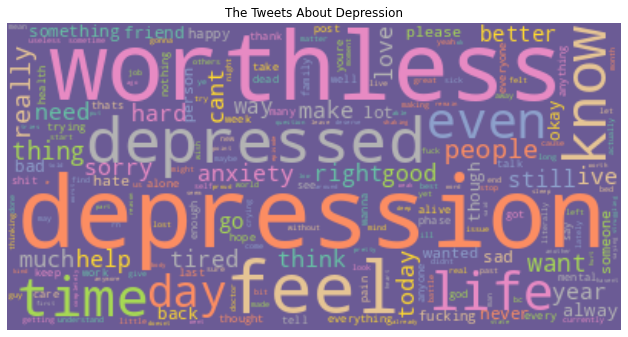

In [ ]:
text = " ".join(i for i in df[df.Label==1].Tweets)
wordcloud = WordCloud(background_color="#6B5B95",colormap="Set2",collocations=False).generate(text)
plt.figure(figsize=[11,11])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("The Tweets About Depression")

Text(0.5, 1.0, 'General Tweets')

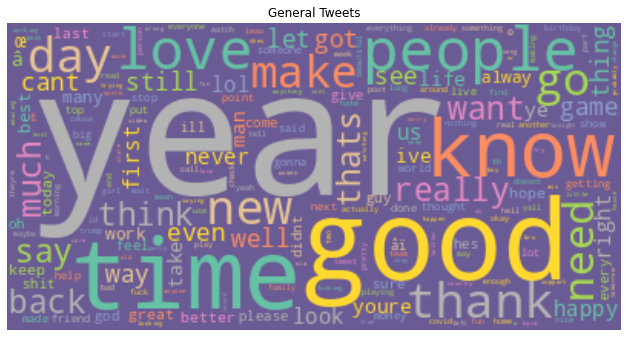

In [ ]:
text = " ".join(i for i in df[df.Label==0].Tweets)
wordcloud = WordCloud(background_color="#6B5B95",colormap="Set2",collocations=False).generate(text)
plt.figure(figsize=[11,11])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("General Tweets")

## Preparing Data for Model Building

In [ ]:
X=df["Tweets"]

In [ ]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(df["Tweets"], df["Label"], test_size=0.4)

In [ ]:
X_train.shape

(7986,)

In [ ]:
X_test.shape

(5325,)

In [ ]:
MAX_LEN = 46
tok = Tokenizer()
tok.fit_on_texts(X)
print(f'Train vocabulary size: {len(tok.word_index)}')

def seq_pad(X):
  # convert to sequences
  sequences = tok.texts_to_sequences(X)
  max_input_len = max(len(sen) for sen in sequences)
  print("Length of longest sentence in input: %g" % max_input_len)  
  # padded sequences
  seq = pad_sequences(sequences,maxlen=MAX_LEN)
  return seq


Train vocabulary size: 17397


In [ ]:
X_train_seq=seq_pad(X_train)
X_test_seq=seq_pad(X_test)

Length of longest sentence in input: 46
Length of longest sentence in input: 38


In [ ]:
X_train_seq

array([[    0,     0,     0, ...,    35, 14494,  1277],
       [    0,     0,     0, ...,     0,   126,   221],
       [    0,     0,     0, ...,     0,     0,     0],
       ...,
       [    0,     0,     0, ...,     9,   265, 14868],
       [    0,     0,     0, ...,    43,   133,    31],
       [    0,     0,     0, ...,   274,  6357,   512]], dtype=int32)

In [ ]:
X_test_seq

array([[    0,     0,     0, ...,    79,     1,    83],
       [    0,     0,     0, ...,   109,   109,   109],
       [    0,     0,     0, ...,     0,   331,    23],
       ...,
       [    0,     0,     0, ...,  1216,  1123, 16613],
       [    0,     0,     0, ...,    77,   662,  2400],
       [    0,     0,     0, ...,   877,     9,   152]], dtype=int32)

###LSTM

In [ ]:
#define the lstm
lstm = Sequential([
    Input(name='inputs',shape=[MAX_LEN]),
    Embedding(len(tok.word_index)+1, 200,name='embedding'),
    LSTM(64, name='lstm-1', return_sequences=True),
    LSTM(32,name='lstm-2'),
    Dense(64, activation='relu',name='dense-1'),
    #Dropout(0.25),
    Dense(1, activation='sigmoid',name='dense-2')
])

#compile lstm
lstm.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#lstm summary
lstm.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)
lstmhist = lstm.fit(X_train_seq, y_train, epochs=20,    
                    validation_split = 0.3, batch_size = 180,callbacks=[es])

train_loss, train_acc = lstm.evaluate(X_train_seq, y_train)
test_loss, test_acc = lstm.evaluate(X_test_seq, y_test)
y_hat1 = lstm.predict(X_test_seq)
y_hat1=np.where(y_hat1 >= 0.5, 1, 0)
print('Train Accuracy:', train_acc)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 46, 200)           3479600   
                                                                 
 lstm-1 (LSTM)               (None, 46, 64)            67840     
                                                                 
 lstm-2 (LSTM)               (None, 32)                12416     
                                                                 
 dense-1 (Dense)             (None, 64)                2112      
                                                                 
 dense-2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3,562,033
Trainable params: 3,562,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
32/32 [==========================

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97      2540
         1.0       0.97      0.97      0.97      2785

    accuracy                           0.97      5325
   macro avg       0.97      0.97      0.97      5325
weighted avg       0.97      0.97      0.97      5325



Text(51.0, 0.5, 'Real Labels')

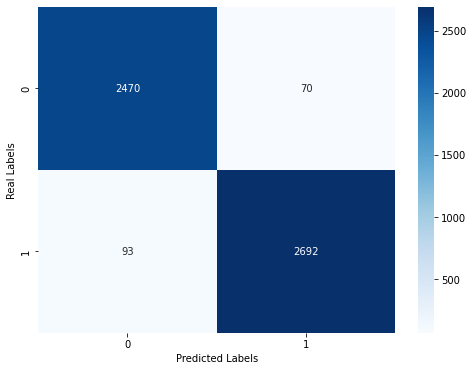

In [ ]:
print(classification_report(y_test, y_hat1))
# confusion matrix
plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix(y_test, np.where(y_hat1 >= 0.5, 1, 0)), annot=True, 
            fmt='', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

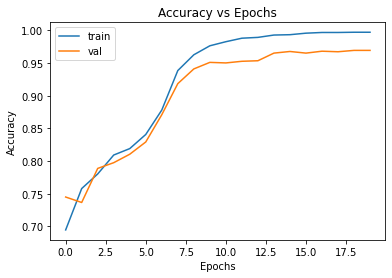

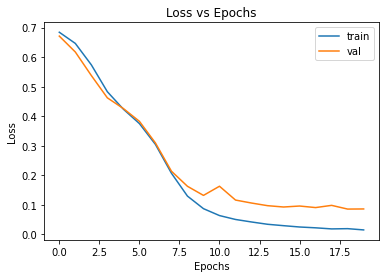

In [ ]:
def plot_hist(string,mod_hist,title=''):
  plt.plot(mod_hist.history[string],label="train")
  plt.plot(mod_hist.history['val_'+string],label="val")
  plt.xlabel("Epochs")
  plt.ylabel(title)
  plt.title(title+" vs Epochs")
  plt.legend()
  plt.show()
plot_hist("accuracy",lstmhist,title="Accuracy")
plot_hist("loss",lstmhist,title="Loss")

###Bi-LSTM

In [ ]:
#define the model
model = Sequential([
    Input(name='inputs',shape=[MAX_LEN]),
    Embedding(len(tok.word_index)+1, 200),
    Bidirectional(LSTM(64,  return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    #Dropout(0.25),
    Dense(1, activation='sigmoid')
])

#compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

#model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 46, 200)           3479600   
                                                                 
 bidirectional (Bidirectiona  (None, 46, 128)          135680    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3,660,721
Trainable params: 3,660,721
No

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)
history = model.fit(X_train_seq, y_train, epochs=10,    
                    validation_split = 0.3, batch_size = 180,callbacks=[es])

Epoch 1/10
32/32 [==============================] - 26s 567ms/step - loss: 0.4964 - accuracy: 0.7928 - val_loss: 0.2772 - val_accuracy: 0.8898
Epoch 2/10
32/32 [==============================] - 17s 521ms/step - loss: 0.0853 - accuracy: 0.9760 - val_loss: 0.0673 - val_accuracy: 0.9800
Epoch 3/10
32/32 [==============================] - 18s 559ms/step - loss: 0.0179 - accuracy: 0.9961 - val_loss: 0.0671 - val_accuracy: 0.9816
Epoch 4/10
32/32 [==============================] - 16s 509ms/step - loss: 0.0089 - accuracy: 0.9986 - val_loss: 0.0749 - val_accuracy: 0.9800
Epoch 5/10
32/32 [==============================] - 16s 508ms/step - loss: 0.0054 - accuracy: 0.9993 - val_loss: 0.0978 - val_accuracy: 0.9779
Epoch 6/10
32/32 [==============================] - 16s 503ms/step - loss: 0.0047 - accuracy: 0.9995 - val_loss: 0.1013 - val_accuracy: 0.9783
Epoch 6: early stopping


In [ ]:
train_loss, train_acc = model.evaluate(X_train_seq, y_train)
test_loss, test_acc = model.evaluate(X_test_seq, y_test)
y_hat = model.predict(X_test_seq)
y_hat=np.where(y_hat >= 0.5, 1, 0)
print('Train Accuracy:', train_acc)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

167/167 [==============================] - 10s 52ms/step
Train Accuracy: 0.9931129217147827
Test Loss: 0.11724885553121567
Test Accuracy: 0.9767135977745056


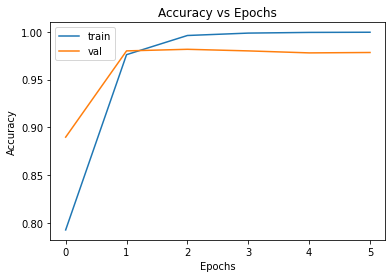

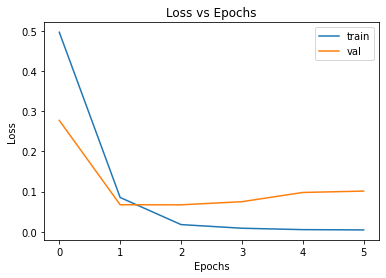

In [ ]:
plot_hist("accuracy",history,"Accuracy")
plot_hist("loss",history,"Loss")

In [ ]:
# classification report
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      2540
         1.0       0.98      0.98      0.98      2785

    accuracy                           0.98      5325
   macro avg       0.98      0.98      0.98      5325
weighted avg       0.98      0.98      0.98      5325



Text(51.0, 0.5, 'Real Labels')

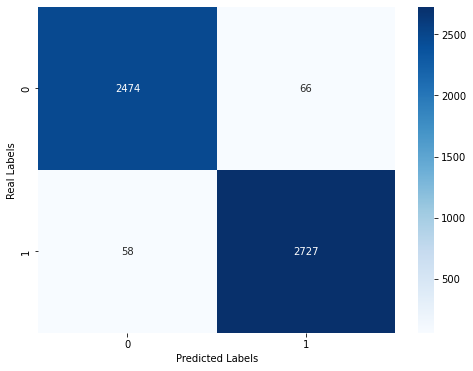

In [ ]:
# confusion matrix
plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix(y_test, np.where(y_hat >= 0.5, 1, 0)), annot=True, 
            fmt='', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

##Valid

In [ ]:
import string
def preprocess_1(text):
  text=text.lower()  
  #text=re.sub("said"," ",text)
  text=re.sub("&amp","&",text)
  text=re.sub('http\S+'," ",text)
  text=re.sub("@[\w]+"," ",text)
  text=re.sub("[{}]".format(string.punctuation+'“”—‘’')," ",text)
  text=re.sub("\d","",text)
  text=[w for w in text.split() if w not in sw]  
  text=[lemma.lemmatize(w) for w in text]
  return ' '.join(text)

In [ ]:
def predict(sent):
  print(sent)
  sent=preprocess_1(sent)
  val_seq=seq_pad([sent])  
  y_hat2 = model.predict(val_seq)
  print(y_hat2)

In [ ]:
predict("feeling sad from past few days")

Length of longest sentence in input: 4
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  274  65 168   8]]
1/1 [==============================] - 0s 30ms/step
[[0.79696584]]


In [ ]:
predict("I went through a time where I was really depressed. Like, I locked myself in my room and my dad had to break my door down")

Length of longest sentence in input: 10
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0  204    6   11    4 1136 3855  369  319  203 1443]]
1/1 [==============================] - 0s 37ms/step
[[0.99805695]]


In [ ]:
predict("I felt threatened by the things my career brought into my life and the pace of my life.")

Length of longest sentence in input: 8
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0  174 2651   14  977  708    9 4127    9]]
1/1 [==============================] - 0s 35ms/step
[[0.9941493]]


In [ ]:
predict("Therapy ... gives you another perspective when you are so lost in your own spiral. ... It helps")

Length of longest sentence in input: 7
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  450   93  158 1609  111 1719   26]]
1/1 [==============================] - 0s 40ms/step
[[0.55392605]]


In [ ]:
predict("At its worst, there was a six-month period ... when I couldn’t dress, days I couldn’t leave the house")

Length of longest sentence in input: 8
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0  206 2558  102  356 2050    8  229  406]]
1/1 [==============================] - 0s 50ms/step
[[0.9860312]]


In [ ]:
predict("Cup of morning coffee to push my negativity away")

cup of morning coffee to push my negativity away
Length of longest sentence in input: 6
1/1 [==============================] - 0s 47ms/step
[[0.00118203]]


In [ ]:
predict("good days are coming don't lose hope")

good days are coming don't lose hope
Length of longest sentence in input: 5
1/1 [==============================] - 0s 67ms/step
[[0.00100949]]


In [ ]:
predict("Today I’m proud to say I’m living proof that someone can live, love and be well with bipolar disorder when they get the education, support and treatment that they need")

Length of longest sentence in input: 16
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0   31  240   39  290
  2017   50  164   21   60  690  811  329 1263  202  841   23]]
1/1 [==============================] - 0s 31ms/step
[[0.02247845]]


In [ ]:
predict("I felt alienated and alone, because I was like, what's wrong with me? I always wanted people to love me, so I never got angry with them; I turned my anger onto myself)

Length of longest sentence in input: 14
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0  174   84
  1136  207   35   53    7   21   34   43  469  791  460 1487]]
1/1 [==============================] - 0s 34ms/step
[[0.9984738]]


In [ ]:
predict("I grew up in L.A., where focus is very inward. I didn’t know why I was so destructive and miserable. I didn’t appreciate or understand my life")

Length of longest sentence in input: 10
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0 1353  573  699 4693    5 2676  611  500  116    9]]
1/1 [==============================] - 0s 34ms/step
[[0.9253701]]


In [ ]:
predict("I couldn’t get out of bed anymore. I felt hopeless, empty, like a zombie.")

Length of longest sentence in input: 8
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0  329  139  210  174  394  404 1136 5142]]
1/1 [==============================] - 0s 37ms/step
[[0.9966146]]


In [ ]:
sent="I used to get a very weird feeling like there was an emptiness inside me I was put on to a psychiatrist medication which went back and forth for many months"
sent=preprocess_1(sent)
val_seq=seq_pad([sent])
print(val_seq)
y_hat2 = lstm.predict(val_seq)
#y_hat2=np.where(y_hat2 >= 0.5, 1, 0)
print(y_hat2)

Length of longest sentence in input: 15
[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0   269   329   427   274  1136  2489   334   143  2237   697   204
     32 13235    73   102]]
1/1 [==============================] - 0s 38ms/step
[[0.9877602]]


In [ ]:
predict("Be happy in life")
predict("I went through a time where I was really depressed. Like, I locked myself in my room and my dad had to break my door down")
predict("I felt threatened by the things my career brought into my life and the pace of my life.")
predict("Therapy ... gives you another perspective when you are so lost in your own spiral. ... It helps")
predict("At its worst, there was a six-month period ... when I couldn’t dress, days I couldn’t leave the house")
predict("Good days are coming, don't lose hope")
predict("Cup of morning coffee to push my negativity away")
predict("Today I’m proud to say I’m living proof that someone can live, love and be well with bipolar disorder when they get the education, support and treatment that they need")
predict("I grew up in L.A., where focus is very inward. I didn’t know why I was so destructive and miserable. I didn’t appreciate or understand my life")
predict("I couldn’t get out of bed anymore. I felt hopeless, empty, like a zombie.")
predict("You are not a failure, and you are not a loser")

Be happy in life
Length of longest sentence in input: 2
1/1 [==============================] - 0s 27ms/step
[[0.02508629]]
I went through a time where I was really depressed. Like, I locked myself in my room and my dad had to break my door down
Length of longest sentence in input: 10
1/1 [==============================] - 0s 24ms/step
[[0.9941077]]
I felt threatened by the things my career brought into my life and the pace of my life.
Length of longest sentence in input: 8
1/1 [==============================] - 0s 23ms/step
[[0.8089176]]
Therapy ... gives you another perspective when you are so lost in your own spiral. ... It helps
Length of longest sentence in input: 7
1/1 [==============================] - 0s 22ms/step
[[0.35580733]]
At its worst, there was a six-month period ... when I couldn’t dress, days I couldn’t leave the house
Length of longest sentence in input: 8
1/1 [==============================] - 0s 24ms/step
[[0.9743561]]
Good days are coming, don't lose hope
Length of